<a id="top"></a>
# Roman Lvl 4 Data Analysis for Time-Domain Astronomy
**************
**************

## Kernel Information

To run this notebook on the Roman Science Platform, please select the "Roman Calibration" kernel at the top right of your window.

## Learning Goals

By the end of this tutorial, you will:

- Display the Roman Open Universe (OU) data
- Create a light curve of OU data
- Create a gif of the data (including the images and light curves) as shown in the gif below. (gif: Courtesy of Wikipedia)

## Imports

- *astropy.table Table* for creating tidy tables of the data
- *matplotlib.pyplot* for plotting
- *sncosmo*  for modeling and fitting light curves
- *numpy* to handle array functions

In [35]:
# Numerical operations
import numpy as np  # For efficient numerical computations and array handling

# Visualization
import matplotlib.pyplot as plt  # For creating plots and figures
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Rectangle, ConnectionPatch, FancyArrow

# Astronomy-specific libraries
from astropy.table import Table  # For table manipulation and stacking
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.wcs import WCS, FITSFixedWarning
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.visualization.wcsaxes import WCSAxes
from astropy.nddata import Cutout2D
import sncosmo  # For modeling and fitting supernova light curves
from photutils.aperture import CircularAperture, aperture_photometry
from scipy.ndimage import rotate

# Data handling
import os
import fsspec
# Initialize fs with an S3 filesystem
fs = fsspec.filesystem('s3', anon=True)  # Set anon=True for public access
import gzip
import imageio.v2 as imageio

import warnings
# Filter out the FITSFixedWarning, which is consequenceless and gets thrown every time you deal with a WCS in a Roman openuniverse simulated image using astropy.
warnings.simplefilter('ignore',category=FITSFixedWarning)

# My modules
import orientation as orient

from reproject import reproject_interp

# Display the final GIF inline
from IPython.display import Image, display

## Introduction

This notebook is designed to provide a simple analysis of Level 4 imaging data products for the Roman Space Telescope with a focus on time-domain astronomy. Herre, we are leveraging the Open Universe (OU) simulated images, however, you can use any other data as well. The notebook processes and analyzes OU data to provide users with advanced data products that can support transient science, including supernovae, variable stars, and other time-sensitive phenomena.
**************

![test](sn2018gv.gif)

## Loading data

This section reads an ECSV file in astropy table format that contains the photometric dataset for a random transient from the OU Roman simulatins. Our example table contains columns such as mjd-obs, flux, filter, and other metadata. Note that you can use and import your own table or dataset of any target, and it does not have to be OU data or in OU format.

If you are interested in learning the details on how the following table was created is shown in step-by-step in several other notebooks available on the Roman Research Nexus (RRN), including:

1) Accessing the dataset already hosted on RRN see [Data access and discovery].

2) The fluxes were obtained using aperture photometry on the target of interest. For more info on aperture photmetry see [photometry](aperture_photometry/aperture_photometry.ipynb).

3) To recreate our example photometric table that we will be using throuthout this notebook, see [creating an example dataset for time domain].

4) If you would like to simulate your own data using romanisim, see [this other notebook].


Please note that:

- The naming convention of the OU data is slightly different than Romanisim.
- You can use an example photometric table from a package called sncosmo using `sncosmo.load_example_data()`.


In [36]:
# Load the input data
LC_table = Table.read('Updated_Matching_Observations.ecsv', format='ascii.ecsv')
lc_data = Table.read('Transformed_for_SNCosmo.ecsv', format='ascii.ecsv')

In [37]:
source_ra=9.61978
source_dec=-44.3138

## Displaying data <a class="anchor" id="2-display"></a>

### Displaying only 2 filters with target of interest highlighted

Here we show how to display a random image from the OU dataset that contains a transient of interest

### Displaying only 1 image with an aperture around the target of interest

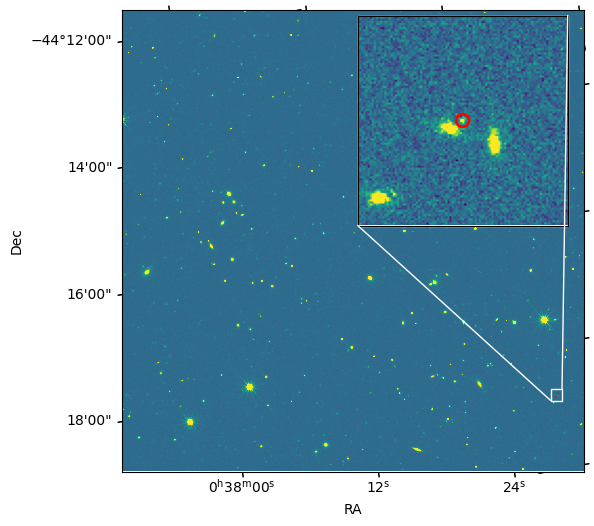

In [38]:
fname = './Roman_TDS_simple_model_R062_407_7.fits.gz'

with gzip.open(fname, 'rb') as f:
    with fits.open(f) as hdul:
        img = hdul[1].data
        wcs = WCS(hdul[1].header)

norm = ImageNormalize(img, interval=ZScaleInterval())
x, y = wcs.world_to_pixel(SkyCoord(ra=source_ra, dec=source_dec, unit='deg'))

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(1, 1, 1, projection=wcs)
ax.imshow(img, norm=norm, cmap='viridis', origin='lower')
ax.set(xlabel='RA', ylabel='Dec')
ax.coords[0].set_major_formatter('hh:mm:ss')
ax.coords[1].set_major_formatter('dd:mm:ss')

CircularAperture((x, y), r=3.0).plot(ax=ax, color='red', lw=2)
cut = 50
ax.add_patch(Rectangle((x - cut, y - cut), 2 * cut, 2 * cut, edgecolor='white', facecolor='none', lw=1))

zoom_ax = fig.add_axes([0.52, 0.52, 0.35, 0.35], projection=wcs)
zoom_ax.imshow(img, norm=norm, cmap='viridis', origin='lower')
zoom_ax.set_xlim(x - cut, x + cut)
zoom_ax.set_ylim(y - cut, y + cut)
CircularAperture((x, y), r=3.0).plot(ax=zoom_ax, color='red', lw=2)

for a, b in [((x + cut, y + cut), (1, 1)), ((x - cut, y - cut), (0, 0))]:
    fig.add_artist(ConnectionPatch(xyA=a, coordsA=ax.transData, xyB=b, coordsB=zoom_ax.transAxes, color='white', lw=1))

for c in zoom_ax.coords:
    c.set_ticks_visible(False)
    c.set_ticklabel_visible(False)

plt.show()


## Light curves <a class="anchor" id="3-LCs"></a>

### Preparing the Input Data

sncosmo expects specific column names for light curve data and in astropy table format.

In this step, we rename:

mjd-obs to time (to represent the Modified Julian Date of the observation).

filter to band (the specific bandpass filter used in the observation).

flux remains unchanged as it's already appropriately named.

(provide a text file that includes all the names of then relevant fits files, tell them that it takes a while to search the entire database, then explain how to do photometry for 1 of those files in the text file, then provide the full ecsv file with the original OU convention that includes the already done photometry for that specific target, and show several ecsv files that each include a different transient, refer to the aperture notebook for further info, we provide the searching funciton in a standalone .py file in within the same directory)

## Plotting a single light curve

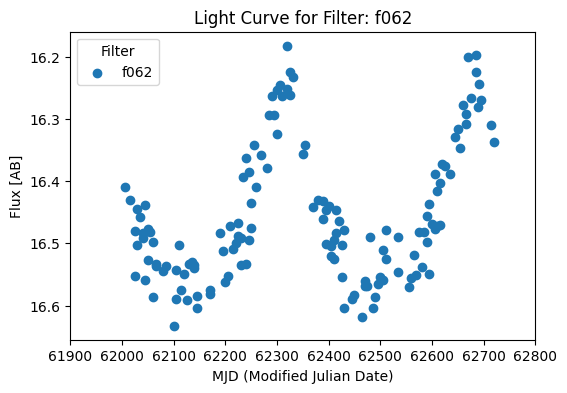

In [39]:
# Define the single filter to plot
single_filter_name = 'f062'  # Replace 'f062' with your desired filter name; for example sdssz if you are using the sncosmo sample data

# Select rows corresponding to the single filter
filter_mask = lc_data['band'] == single_filter_name
group = lc_data[filter_mask]

# Check if the filter exists in the data
if not np.any(filter_mask):
    raise ValueError(f"Filter '{single_filter_name}' not found in the data.")
    
# Plot time vs. flux for the selected filter
plt.figure(figsize=(6, 4))
plt.scatter(group['time'], group['flux'], label=single_filter_name)

# Customize the plot
plt.xlabel("MJD (Modified Julian Date)")
plt.ylabel("Flux [AB]")
plt.xlim(61900,62800)
plt.title(f"Light Curve for Filter: {single_filter_name}")
plt.legend(title="Filter")
plt.gca().invert_yaxis()  # Invert y-axis for magnitudes (lower mags are brighter)
plt.show()

## Plotting a light curve of all filters

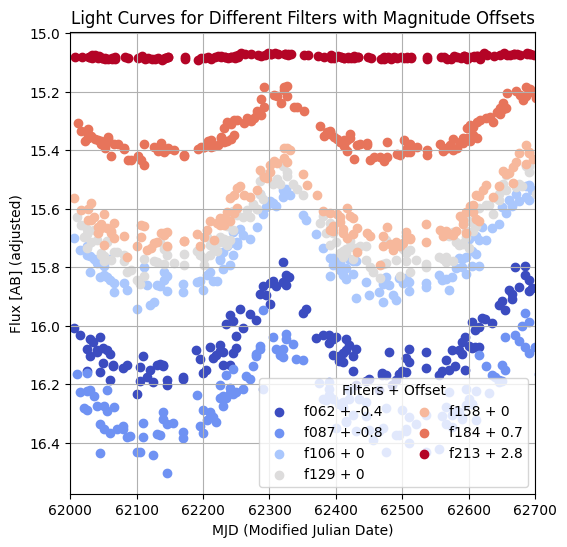

In [43]:
# Group by filters and plot
plt.figure(figsize=(6, 6))

# Get unique filter names and assign them a color map
filter_names = sorted(np.unique(lc_data['band']))  # Sort filters by name
cmap = plt.colormaps.get_cmap('coolwarm')  # Updated to use modern colormap getter
norm = ImageNormalize(vmin=0, vmax=len(filter_names) - 1)  # Normalize for filter indices

# Ensure the 'flux' column is numeric
lc_data['flux'] = np.asarray(lc_data['flux'], dtype=float)  # Convert to numeric
mask_valid_flux = ~np.isnan(lc_data['flux'])  # Mask for valid flux values
lc_data = lc_data[mask_valid_flux]  # Keep only rows with valid flux values

# Initialize the magnitude offset
offset = [-0.4,-0.8,0,0,0,0.7,2.8]

# Iterate through each filter and plot
for idx, filter_name in enumerate(filter_names):
    # Select rows corresponding to the current filter
    filter_mask = lc_data['band'] == filter_name
    group = lc_data[filter_mask]
    
    # Apply the magnitude offset
    adjusted_flux = group['flux'] + offset[idx]
    
    # Plot time vs. adjusted flux for the current filter
    plt.scatter(group['time'], adjusted_flux, label=f"{filter_name} + {offset[idx]}", 
                color=cmap(norm(idx)))
    
    # Increment the magnitude offset for the next filter
    # offset += 1

# Customize the plot
plt.xlabel("MJD (Modified Julian Date)")
plt.ylabel("Flux [AB] (adjusted)")
plt.title("Light Curves for Different Filters with Magnitude Offsets")
plt.legend(title="Filters + Offset", ncols=2)
plt.gca().invert_yaxis()  # Invert y-axis for magnitudes (lower mags are brighter)

# # Add a dummy ScalarMappable for the colorbar
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
# cbar = plt.colorbar(sm, orientation='vertical', pad=0.02)
# cbar.set_label('Filter Index (blue -> red)')
plt.xlim(62000,62700)
plt.grid(True)
plt.show()


(let's make a cutout of the target of interest, and then save the cutouts as new fits files with the wcs and everything for all the images and then make the gif of those cutouts instead of a gif of the entire FOV, the cutouts and the gif will be the third notebook)

# Let's display a gif of the images that corresponds to the above light curve!

Fetching: s3://nasa-irsa-simulations/openuniverse2024/roman/full/RomanTDS/images/simple_model/R062/407/Roman_TDS_simple_model_R062_407_7.fits.gz
Fetching: s3://nasa-irsa-simulations/openuniverse2024/roman/full/RomanTDS/images/simple_model/Y106/517/Roman_TDS_simple_model_Y106_517_7.fits.gz
Fetching: s3://nasa-irsa-simulations/openuniverse2024/roman/full/RomanTDS/images/simple_model/H158/627/Roman_TDS_simple_model_H158_627_7.fits.gz
Fetching: s3://nasa-irsa-simulations/openuniverse2024/roman/full/RomanTDS/images/simple_model/K213/737/Roman_TDS_simple_model_K213_737_7.fits.gz
Fetching: s3://nasa-irsa-simulations/openuniverse2024/roman/full/RomanTDS/images/simple_model/Z087/847/Roman_TDS_simple_model_Z087_847_7.fits.gz
GIF saved at /Users/mshahbandeh/Roman/roman_notebooks-test/content/notebooks/fits_cutout.gif


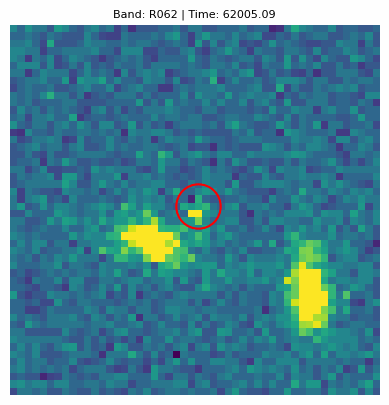

In [34]:
def create_cutout_fits_gif(
    lc_table, aperture_radius, n_images,
    bucket_name, prefix, source_ra, source_dec,
    save_dir, output_gif="fits_cutout.gif", cutout_size=50
):
    """
    Generate a GIF from small cutouts around a target in aligned FITS images.

    Parameters:
        cutout_size (int): Size (in pixels) of the square cutout around the source.
    """
    fs = filesystem('s3', anon=True)
    os.makedirs(save_dir, exist_ok=True)

    selected_rows = lc_table[:n_images]
    frames = []

    reference_wcs = None
    reference_shape = None

    for i, row in enumerate(selected_rows):
        fits_file_path = f"s3://{bucket_name}/{prefix}/{row['filter']}/{row['obs_id']}/{row['filename']}.gz"
        print(f"Fetching: {fits_file_path}")

        try:
            with fs.open(fits_file_path, mode='rb') as compressed_file:
                with gzip.GzipFile(fileobj=compressed_file) as uncompressed_file:
                    with fits.open(uncompressed_file) as hdul:
                        img = hdul[1].data
                        header = hdul[0].header
                        wcs = WCS(header)

            if reference_wcs is None:
                reference_wcs = wcs
                reference_shape = img.shape

            aligned_img, _ = reproject_interp((img, wcs), reference_wcs, shape_out=reference_shape)
            target_x, target_y = reference_wcs.all_world2pix(source_ra, source_dec, 0)

            # Create cutout centered on source
            cutout = Cutout2D(aligned_img, (target_x, target_y), cutout_size, wcs=reference_wcs)

            norm = ImageNormalize(cutout.data, interval=ZScaleInterval())
            fig, ax = plt.subplots()
            ax.imshow(cutout.data, norm=norm, cmap='viridis', origin='lower')

            # Draw aperture (now centered in cutout coords)
            aperture = CircularAperture((cutout.data.shape[1] / 2, cutout.data.shape[0] / 2), r=aperture_radius)
            aperture.plot(color='red', lw=1.5, ax=ax)

            ax.set_title(f"Band: {row['filter']} | Time: {row['mjd-obs']:.2f}", fontsize=8)
            ax.axis('off')

            frame_path = os.path.join(save_dir, f"cutout_frame_{i}.png")
            plt.savefig(frame_path, bbox_inches='tight', dpi=100)
            frames.append(imageio.imread(frame_path))
            plt.close()

        except Exception as e:
            print(f"Error processing {fits_file_path}: {e}")

    if frames:
        gif_path = os.path.join(save_dir, output_gif)
        imageio.mimsave(gif_path, frames, duration=2)
        print(f"GIF saved at {gif_path}")

        for i in range(len(frames)):
            os.remove(os.path.join(save_dir, f"cutout_frame_{i}.png"))
    else:
        print("No valid frames to create GIF.")

# Call the function
create_cutout_fits_gif(
    lc_table=LC_table,
    aperture_radius=3.0,
    n_images=5,
    bucket_name="nasa-irsa-simulations",
    prefix="openuniverse2024/roman/full/RomanTDS/images/simple_model",
    source_ra=source_ra,
    source_dec=source_dec,
    save_dir='/Users/mshahbandeh/Roman/roman_notebooks-test/content/notebooks/',
    output_gif="fits_cutout.gif",
    cutout_size=50
)

display(Image('/Users/mshahbandeh/Roman/roman_notebooks-test/content/notebooks/fits_cutout.gif'))

## Additional resources <a class="anchor" id="6-ADs"></a>

- [Roman User Documentation -- RDox](https://roman-docs.stsci.edu/)
- [RDox WFI Data Levels and Products](https://roman-docs.stsci.edu/data-handbook-home/wfi-data-format/data-levels-and-products#DataLevelsandProducts-L2ScienceDataSpecifications)
- [Roman Help Desk](https://roman-docs.stsci.edu/roman-help-desk-at-stsci)

## About this notebook <a class="anchor" id="7-About"></a>

**Author:** [Melissa Shahbandeh](https://github.com/shahbandeh/roman_notebooks/tree/time-domain/content/notebooks/time_domain_analysis)  

**Updated On:** 2025-03-25

**************

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 